In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, ActivityRegularization
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import matplotlib.mlab as mlab
import seaborn as sns
import time

Using TensorFlow backend.
/home/veruska/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/veruska/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/veruska/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/veruska/.local/lib/python3.6/site-packages/tensorflow/py

In [2]:
data_path = '../../data/output/normalized_data_X.csv'
y_path = '../../data/output/y.csv'

data = pd.read_csv(data_path)
y = pd.read_csv(y_path)
print(data.shape)
print(y.shape)
data.head()

(1432633, 420)
(1432633, 1)


,route,tripNum,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,gpsLon,...,alertTypeSB_ACCIDENT,alertTypeSB_CHIT_CHAT,alertTypeSB_HAZARD,alertTypeSB_JAM,alertTypeSB_NORMAL,alertTypeSB_POLICE,alertTypeSB_ROAD_CLOSED,jamBlockTypeSB_-,jamBlockTypeSB_NORMAL,jamBlockTypeSB_ROAD_CLOSED_EVENT
0,0.118068,0.066667,0.085019,0.264600,0.496150,0.057584,0.0,0.000000,0.266155,0.496047,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.118068,0.066667,0.085026,0.270218,0.501802,0.064231,0.0,0.000148,0.271812,0.501642,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.118068,0.066667,0.085033,0.273653,0.505296,0.068301,0.0,0.000000,0.275187,0.505192,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.118068,0.066667,0.085039,0.277433,0.509404,0.072900,0.0,0.000149,0.280622,0.510132,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.118068,0.066667,0.085053,0.280050,0.513166,0.077983,0.0,0.000155,0.281878,0.513178,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [1]:
# FILTERING HIGHER HEADWAYS (2% of the data)
# two_hours = 120
# data = data[data.headway <= two_hours]

In [ ]:
print(min(data["headway"]))
print(max(data["headway"]))

In [3]:
data.shape

(1432633, 423)

In [12]:
data.columns

Index(['route', 'tripNum', 'shapeSequence', 'shapeLat', 'shapeLon',
       'distanceTraveledShape', 'busCode', 'gpsPointId', 'gpsLat', 'gpsLon',
       ...
       'alertTypeSB_ACCIDENT', 'alertTypeSB_CHIT_CHAT', 'alertTypeSB_HAZARD',
       'alertTypeSB_JAM', 'alertTypeSB_NORMAL', 'alertTypeSB_POLICE',
       'alertTypeSB_ROAD_CLOSED', 'jamBlockTypeSB_-', 'jamBlockTypeSB_NORMAL',
       'jamBlockTypeSB_ROAD_CLOSED_EVENT'],
      dtype='object', length=423)

In [13]:
data.isnull().any()

route                               False
tripNum                             False
shapeSequence                       False
shapeLat                            False
shapeLon                            False
                                    ...  
alertTypeSB_POLICE                  False
alertTypeSB_ROAD_CLOSED             False
jamBlockTypeSB_-                    False
jamBlockTypeSB_NORMAL               False
jamBlockTypeSB_ROAD_CLOSED_EVENT    False
Length: 423, dtype: bool

In [4]:
data["headwayThreshold"]

0          5
1          5
2          5
3          5
4          5
          ..
1432628    5
1432629    5
1432630    5
1432631    5
1432632    5
Name: headwayThreshold, Length: 1432633, dtype: int64

In [8]:
data[data["headwayThreshold"] != 5]["headwayThreshold"]

280        4
281        4
493        4
494        4
495        4
          ..
1432399    1
1432402    0
1432496    3
1432521    4
1432605    2
Name: headwayThreshold, Length: 216222, dtype: int64

In [3]:
target_col = ['headway']
bb_col = ['busBunching']
hd_threshold = ["headwayThreshold"]
features = list(set(list(data.columns))-set(target_col)-set(bb_col)-set(hd_threshold))

In [ ]:
# Balancing data


In [4]:
# Get label column and remove it from data
y = data['busBunching']
y_threshold = data['headwayThreshold']

data.drop('headway', axis=1, inplace=True)
data.drop('busBunching', axis=1, inplace=True)
data.drop('headwayThreshold', axis=1, inplace=True)

In [5]:
# Normalize data
min_max_scaler = preprocessing.MinMaxScaler()
data_scale = min_max_scaler.fit_transform(data)

In [8]:
data_scale

array([[0.11806798, 0.06666667, 0.08501909, ..., 1.        , 0.        ,
        0.        ],
       [0.11806798, 0.06666667, 0.08502585, ..., 0.        , 1.        ,
        0.        ],
       [0.11806798, 0.06666667, 0.08503261, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.24329159, 0.03333333, 0.26465479, ..., 0.        , 1.        ,
        0.        ],
       [0.24329159, 0.03333333, 0.26469535, ..., 0.        , 1.        ,
        0.        ],
       [0.24329159, 0.06666667, 0.26188368, ..., 0.        , 1.        ,
        0.        ]])

In [4]:
# Making training and test data: 80% Training, 20% Test
random.seed(15) #to get always the same set
train_X, test_X, train_Y, test_Y = train_test_split(data, y, test_size=0.20, random_state=7)

In [8]:
train_X

array([[0.64579606, 0.03333333, 0.60542733, ..., 1.        , 0.        ,
        0.        ],
       [0.25402504, 0.26666667, 0.40558954, ..., 1.        , 0.        ,
        0.        ],
       [0.64579606, 0.06666667, 0.60804974, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.15026834, 0.03333333, 0.1252543 , ..., 1.        , 0.        ,
        0.        ],
       [0.28085868, 0.1       , 0.30555912, ..., 1.        , 0.        ,
        0.        ],
       [0.12880143, 0.16666667, 0.09351492, ..., 1.        , 0.        ,
        0.        ]])

In [13]:
train_Y

223035       8
704879       1
1412767      6
486302      27
203578       4
          ... 
839891     100
535030       6
573977      28
1238212     52
585903      23
Name: headway, Length: 1146106, dtype: int64

In [15]:
y[223035]

8

### ANN

In [5]:
# Getting training time
start = time.time()

# Define model - Deep Feed Forward
model = Sequential()
model.add(Dense(350, input_dim=len(features), activation= "relu"))
model.add(Dense(350, activation= "relu"))
model.add(Dense(350, activation= "relu"))
model.add(Dense(300, activation= "relu"))
model.add(Dense(300, activation= "relu"))
model.add(Dense(300, activation= "relu"))
model.add(Dense(250, activation= "relu"))
model.add(Dense(250, activation= "relu"))
model.add(Dense(250, activation= "relu"))
model.add(Dense(250, activation= "relu"))
model.add(Dense(200, activation= "relu"))
model.add(Dense(200, activation= "relu"))
model.add(Dense(200, activation= "relu"))
model.add(Dense(200, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu")) #40 hidden layers

model.add(Dense(1, activation='sigmoid'))
# model.add(Dense(1)) #headway
#print(model.summary()) #Print model Summary

# Compile model
model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
# model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

# Fit Model
model_history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=100, batch_size=128)

# Saving a pickle file for the model
#joblib.dump(model, 'Saved_ANN_40_BB.pkl')

end = time.time()
print("Execution time:" + str((end - start)/60) + "min")

W0111 18:46:11.328546 140347798427456 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0111 18:46:11.336818 140347798427456 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0111 18:46:11.338281 140347798427456 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0111 18:46:11.664234 140347798427456 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0111 18:46:11.6

Train on 1146106 samples, validate on 286527 samples
Epoch 1/100
1146106/1146106 [==============================] - 75s 66us/step - loss: 0.4000 - acc: 0.8644 - val_loss: 0.3951 - val_acc: 0.8654
Epoch 2/100
1146106/1146106 [==============================] - 75s 65us/step - loss: 0.3970 - acc: 0.8644 - val_loss: 0.3951 - val_acc: 0.8654
Epoch 3/100
1146106/1146106 [==============================] - 75s 65us/step - loss: 0.3970 - acc: 0.8644 - val_loss: 0.3952 - val_acc: 0.8654
Epoch 4/100
1146106/1146106 [==============================] - 75s 65us/step - loss: 0.3970 - acc: 0.8644 - val_loss: 0.3951 - val_acc: 0.8654
Epoch 5/100
1146106/1146106 [==============================] - 75s 65us/step - loss: 0.3970 - acc: 0.8644 - val_loss: 0.3951 - val_acc: 0.8654
Epoch 6/100
1146106/1146106 [==============================] - 75s 65us/step - loss: 0.3962 - acc: 0.8644 - val_loss: 0.3901 - val_acc: 0.8654
Epoch 7/100
1146106/1146106 [==============================] - 75s 65us/step - loss: 0.36

### Tuning hiper parameters

In [7]:
def train_model(activation, loss, optimizer, batch_size):
    # Define model
    model = Sequential()
    model.add(Dense(200, input_dim=len(features), activation=activation))
    model.add(Dense(150, activation=activation))
    model.add(Dense(100, activation=activation))
    model.add(Dense(50, activation=activation))
    model.add(Dense(25, activation=activation))
    model.add(Dense(1))
    #print(model.summary()) #Print model Summary

    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=["mean_squared_error"])
    model.fit(train_X, train_Y, epochs=100, batch_size=batch_size)
    return model

In [8]:
del data
del data_scale
del y

In [8]:
parameters = {'activation': ['relu', 'elu', 'tanh'],
              'optimizer': ['adam', 'nadam', 'sgd'],
              'loss': ['mse', 'mape'],
              'batch_size': [16, 32, 64, 128]}

model = KerasRegressor(build_fn=train_model)
gridSearch = GridSearchCV(estimator=model,
                          param_grid=parameters,
                          cv=10,
                          n_jobs=8,
                          return_train_score=True).fit(train_X, train_Y)

E0917 08:23:34.075292 140307966428928 _base.py:627] exception calling callback for <Future at 0x7f9bd24298d0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/_parallel_back

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

In [8]:
print('Grid Search Best score', gridSearch.best_score_)
print('Grid Search Best Parameters', gridSearch.best_params_)
print('Execution time', gridSearch.refit_time_)

Grid Search Best score -2629.2178188476564
Grid Search Best Parameters {'activation': 'relu', 'batch_size': 128, 'loss': 'mse', 'optimizer': 'adam'}
Execution time 106.91241836547852


### LSTM

In [46]:
def get_window_y(train_y, window, isTest, sample_size):
    y_window = []
    
    for i in range(window,len(train_y),window): #skip the first one
        if (isTest):
            y_window.append(train_y[i+sample_size])
        else:
            y_window.append(train_y[i])
    y_window.append(train_y[train_y.index[-1]])   
    
    return y_window

In [9]:
a = np.split(train_X, len(train_X)/window)

In [11]:
np.array(a)

KeyError: 0

In [5]:
sample_size = 1000000
# sample_size = 80000
window = 1

train_X, test_X = data[0:sample_size], data[sample_size:]
# train_y, test_y = get_window_y(y[0:sample_size], window, False, sample_size), get_window_y(y[sample_size:-4], window, True, sample_size)
train_y, test_y = y.values[0:sample_size], y.values[sample_size:]

train_X_window = np.split(train_X, len(train_X)/window)
test_X_window = np.split(test_X, len(test_X)/window)

train_y_window = np.split(train_y, len(train_y)/window)
test_y_window = np.split(test_y, len(test_y)/window)
# train_y_window = np.array(train_y)
# test_y_window = np.array(test_y)

In [ ]:
# Getting training time
start = time.time()

model = Sequential()
# model.add(Dense(200, input_dim=(window, len(features)), activation= "relu"))
model.add(LSTM(300, activation='relu', return_sequences=True, 
               input_shape=(window, len(features))))
model.add(LSTM(250, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(150, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
# model.add(Dense(25))
model.add(Dense(1))

model.compile(loss= "binary_crossentropy" , optimizer="adam", metrics=["accuracy"])
model_history = model.fit(train_X_window, train_y_window, epochs=100, batch_size=128)

end = time.time()
print("Execution time:" + str((end - start)/60) + "min")

W0111 22:09:51.480144 139923556325184 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0111 22:09:51.693658 139923556325184 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0111 22:09:51.770317 139923556325184 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0111 22:09:52.848354 139923556325184 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0111 22:09:52.8

In [7]:
model

### Evaluating model

In [9]:
# Testing
# ann_load = joblib.load('Saved_ANN_40.pkl')
# pred_array = ann_load.predict(test_X)

pred_array = model.predict(test_X_window)
pred_array

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 432633 arrays: [array([[2.50447227e-01, 2.33333333e-01, 4.01642391e-01, 8.45647664e-01,
        6.66858208e-01, 3.88648698e-02, 9.88065632e-01, 0.00000000e+00,
        8.45915537e-01, 6.66720150e-01, 0.00000000e+00,...

In [ ]:
pred_array

In [13]:
# removing the array of each element
pred = []
for p in pred_array:
    pred.append(p[0])

In [14]:
pred_bb = []
for x in pred:
    if x <= 0.5:
        pred_bb.append(0)
    else:
        pred_bb.append(1)

pred_bb

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [15]:
pred

[0.0035571158,
 0.09046468,
 0.059907645,
 0.10156003,
 0.014056087,
 0.00022867322,
 0.002495855,
 0.15962169,
 0.0070855618,
 0.0032605529,
 2.413988e-06,
 0.033956498,
 0.3264001,
 0.66340935,
 0.090081215,
 0.002629131,
 0.014113605,
 0.58865917,
 0.009982437,
 0.24289256,
 0.8817614,
 0.23168251,
 6.070733e-05,
 0.074741244,
 0.19587079,
 0.005819559,
 0.0072328746,
 0.05703494,
 0.002472341,
 0.2196458,
 0.28496784,
 0.0001642704,
 0.8834175,
 2.6732683e-05,
 0.006641388,
 0.44439226,
 0.0068160594,
 0.29947606,
 8.571148e-05,
 0.00023123622,
 0.9742989,
 0.24824646,
 0.00011613965,
 0.23532844,
 0.43941614,
 6.553531e-05,
 0.0031362474,
 0.0001668632,
 0.0021490753,
 9.298325e-06,
 0.013863355,
 0.00019800663,
 0.57687825,
 0.00014463067,
 0.000102072954,
 0.2573365,
 0.00012740493,
 0.0003517866,
 0.0001424253,
 0.28365582,
 0.00033956766,
 0.0004644692,
 0.033374906,
 0.18725589,
 0.0043337643,
 0.0017672777,
 1.180172e-05,
 0.39330256,
 0.00089621544,
 0.3291561,
 0.5039713,


In [18]:
test_Y

341586     0
573490     1
50737      0
840747     0
796060     0
          ..
1421784    0
514588     1
1169290    0
1023921    0
988420     0
Name: busBunching, Length: 286527, dtype: int64

In [8]:
alpha = y_threshold[test_Y.index]
# alpha = y_threshold[sample_size:]
alpha

341586     5
573490     4
50737      5
840747     5
796060     5
          ..
1421784    5
514588     6
1169290    5
1023921    5
988420     5
Name: headwayThreshold, Length: 286527, dtype: int64

In [9]:
bb_pred = np.less_equal(pred, alpha)
bb_label = np.less_equal(test_Y, alpha)
# bb_label = np.less_equal(test_y_window, alpha)

In [14]:
bb_pred

341586     False
573490     False
50737      False
840747     False
796060     False
           ...  
1421784    False
514588     False
1169290    False
1023921    False
988420     False
Name: headwayThreshold, Length: 286527, dtype: bool

In [15]:
bb_label

341586     False
573490      True
50737      False
840747     False
796060     False
           ...  
1421784    False
514588      True
1169290    False
1023921    False
988420     False
Length: 286527, dtype: bool

In [16]:
# Bus Bunching
accuracy = accuracy_score(test_Y, pred_bb)
precision = precision_score(test_Y, pred_bb)
recall = recall_score(test_Y, pred_bb)
f_measure = f1_score(test_Y, pred_bb)

In [10]:
accuracy = accuracy_score(bb_label, bb_pred)
precision = precision_score(bb_label, bb_pred)
recall = recall_score(bb_label, bb_pred)
f_measure = f1_score(bb_label, bb_pred)

In [17]:
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F-measure: " + str(f_measure))

Accuracy: 0.8988472290569475
Precision: 0.7248101977692379
Recall: 0.4009124607927003
F-measure: 0.5162647083368105


In [8]:
width = 5
height = 5

In [6]:
model_history.history

{'val_loss': [0.3951343899791024,
  0.3951146406975223,
  0.3951595703681526,
  0.395103416575545,
  0.395097999426937,
  0.39006515224577887,
  0.3528700749072938,
  0.35165515197312885,
  0.3362059212200635,
  0.34092139141020494,
  0.3281488119745622,
  0.33264767406233314,
  0.32057325054483227,
  0.33689703308913194,
  0.32339891378269375,
  0.315070039880404,
  0.3148909568818449,
  0.31179522238192153,
  0.3132407967339669,
  0.3122076323459104,
  0.3113939168166438,
  0.3146504944859617,
  0.31087745997492156,
  0.3045300883910463,
  0.3067384188632614,
  0.3056746351391763,
  0.3073023071107628,
  0.30395671719568057,
  0.300560586163588,
  0.3099942617430265,
  0.3001215737386816,
  0.30125823936408375,
  0.3066063319157549,
  0.3034327523205744,
  0.2970599654843131,
  0.2988241026386059,
  0.29798146977323214,
  0.29636831311680734,
  0.30062720318013725,
  0.293928039973827,
  0.3023516264511626,
  0.2951561896486366,
  0.2911656213936192,
  0.29189796313850597,
  0.289179

In [ ]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

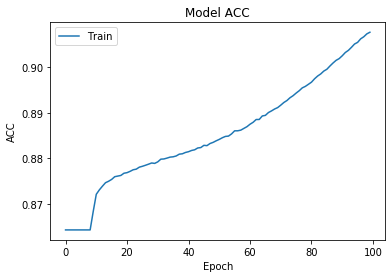

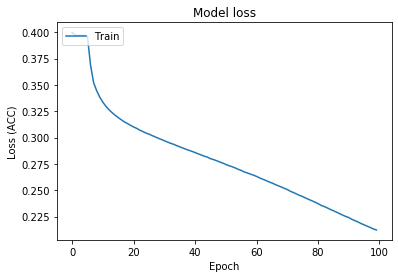

In [9]:
# Plot training & validation accuracy values
plt.plot(model_history.history['acc'])
plt.title('Model ACC')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss (ACC)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [26]:
mse = mean_squared_error(test_Y, pred_bb)
rmse_ann = np.sqrt(mse)
print(rmse_ann)

0.31696250040463425


In [10]:
print(min(pred))
print(max(pred))

[0.6462879]
[596.6783]


Text(0.5, 1.0, 'Residuals')

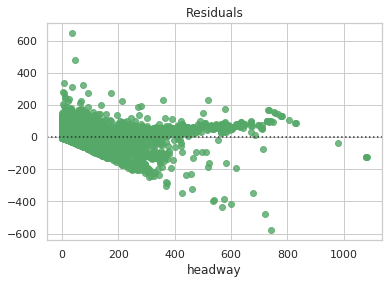

In [22]:
sns.set(style="whitegrid")

# Plot the residuals after fitting a linear model
sns.residplot(test_Y, pred, color="g").set_title('Residuals')

Residuals should not have a standard.

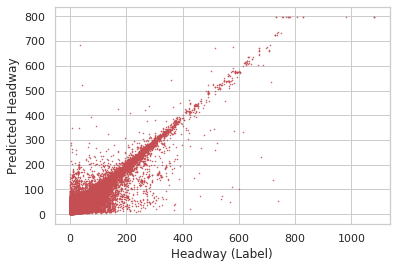

In [23]:
# Print all error to see if there is standard or some big outliers
plt.figure()
plt.plot(test_Y, pred, 'ro', ms=0.5)
plt.xlabel('Headway (Label)')
plt.ylabel('Predicted Headway')
plt.show()

NameError: name 'width' is not defined

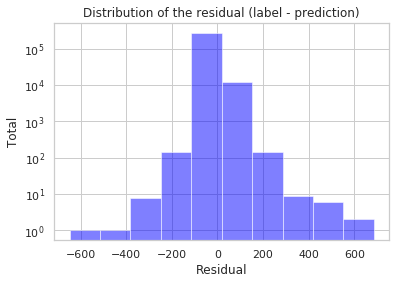

In [24]:
diff = test_Y - np.array(pred).flatten()
num_bins = 10
plt.hist(diff, num_bins, facecolor='blue', alpha=0.5, log=True)
plt.xlabel('Residual')
plt.ylabel('Total')
plt.title('Distribution of the residual (label - prediction)')
plt.rcParams["figure.figsize"] = (width,height) 
plt.show()

In [ ]:
model_history.history